# Assignment 4: Pipelines and Hyperparameter Tuning (32 total marks)
### Due: November 22 at 11:59pm

### Name: 

### In this assignment, you will be putting together everything you have learned so far. You will need to find your own dataset, do all the appropriate preprocessing, test different supervised learning models and evaluate the results. More details for each step can be found below.

### You will also be asked to describe the process by which you came up with the code. More details can be found below. Please cite any websites or AI tools that you used to help you with this assignment.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt


## Step 1: Data Input (4 marks)

Import the dataset you will be using. You can download the dataset onto your computer and read it in using pandas, or download it directly from the website. Answer the questions below about the dataset you selected. 

To find a dataset, you can use the resources listed in the notes. The dataset can be numerical, categorical, text-based or mixed. If you want help finding a particular dataset related to your interests, please email the instructor.

**You cannot use a dataset that was used for a previous assignment or in class**

In [2]:
# Import dataset (1 mark)
astro_df = pd.read_csv('star_classification.csv')
# Remove target column, as well as all columns which are metadata about the collection, and not necessarily features.
X = astro_df.drop(columns=['class', 'alpha', 'delta', 'obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID'])
y = astro_df['class']

In [3]:
print(X.head())
print(y.head())

          u         g         r         i         z  redshift
0  23.87882  22.27530  20.39501  19.16573  18.79371  0.634794
1  24.77759  22.83188  22.58444  21.16812  21.61427  0.779136
2  25.26307  22.66389  20.60976  19.34857  18.94827  0.644195
3  22.13682  23.77656  21.61162  20.50454  19.25010  0.932346
4  19.43718  17.58028  16.49747  15.97711  15.54461  0.116123
0    GALAXY
1    GALAXY
2    GALAXY
3    GALAXY
4    GALAXY
Name: class, dtype: object


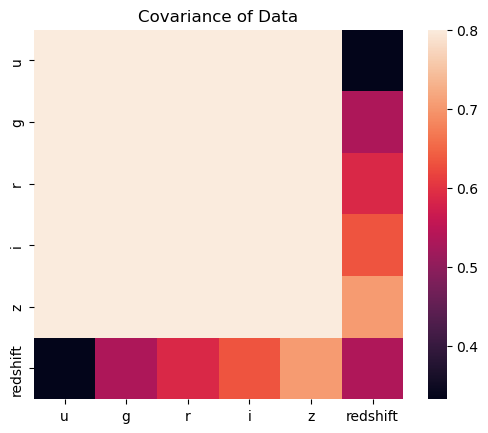

In [4]:
cov = X.cov()
sns.heatmap(cov, vmax=.8, square=True)
plt.title("Covariance of Data")
plt.show()

## Investigating the features

c:\Users\chris\anaconda3\envs\ensf-ml\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\chris\anaconda3\envs\ensf-ml\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


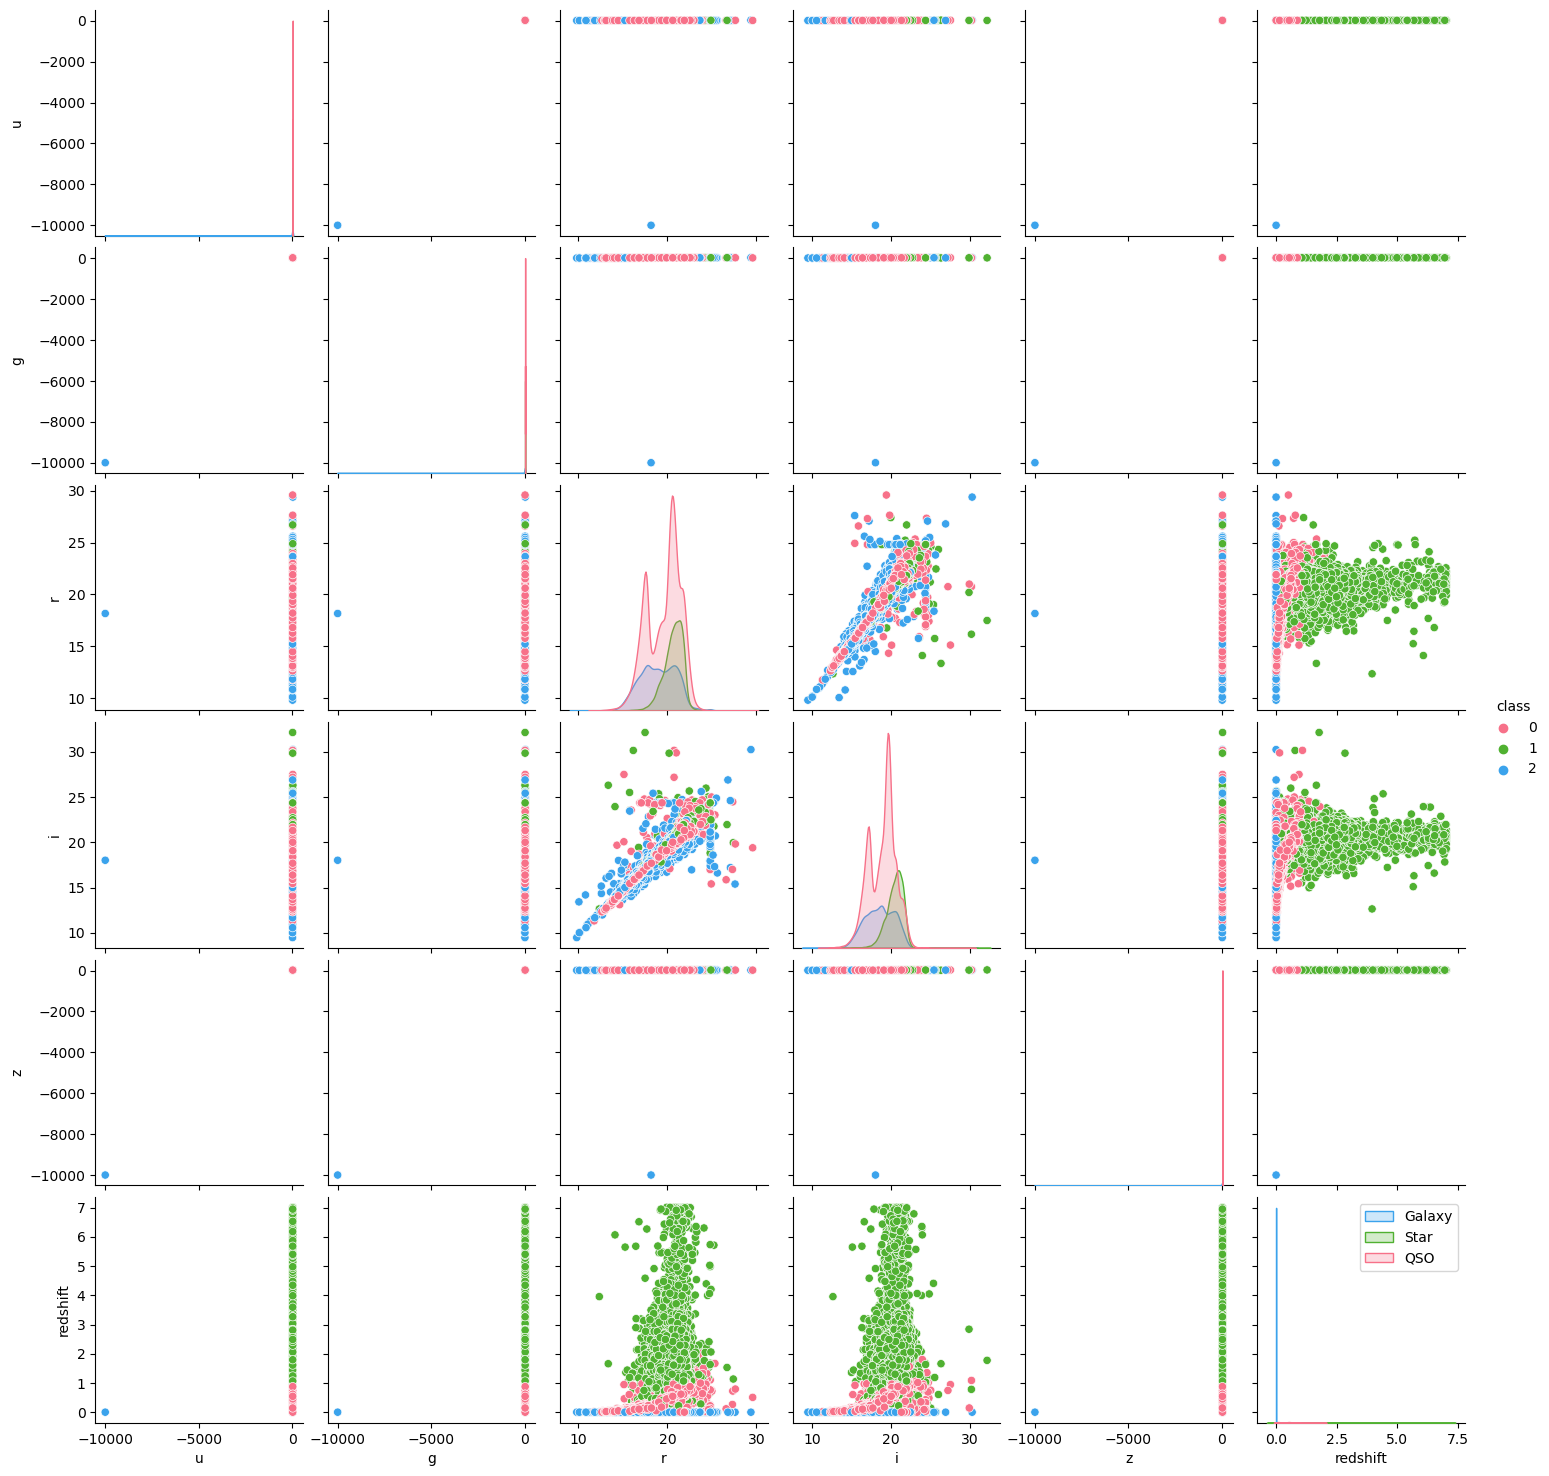

In [5]:
from sklearn.preprocessing import LabelEncoder
data_vis = astro_df.drop(columns=['alpha', 'delta', 'obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID'])
enc = LabelEncoder()
targets = ['GALAXY', 'STAR', 'QSO']
enc.fit(targets)
data_vis['class'] = enc.transform(data_vis[['class']])
sns.pairplot(data_vis, hue='class', palette=sns.color_palette('husl', 3))
plt.legend(labels=['Galaxy', 'Star', 'QSO'])
plt.show()

### Questions (3 marks)

1. (1 mark) What is the source of your dataset?
   
   The data I used is multispectral astrophotography data, captured by the Sloan Digital Sky Survey, uploaded to Kaggle. Available at: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17 and 
    https://www.sdss4.org/science/image-gallery/ 

1. (1 mark) Why did you pick this particular dataset?

    I thought that it would be interesting to work on a classification problem with multiple target classes, and I have an interest in astrophotography. 
    
1. (1 mark) Was there anything challenging about finding a dataset that you wanted to use?

    It was difficult to find a balance when selecting a dataset of the right complexity level. Many 'tutorial' datasets were very simple and gave excellent ML results no matter the techniques used. Other real-world datasets were overly complex and extremely difficult to clean and model.


## Step 2: Data Processing (5 marks)

The next step is to process your data. Implement the following steps as needed.

In [6]:
# Clean data (if needed)
print(X.isna().sum())
print(X.dtypes)


u           0
g           0
r           0
i           0
z           0
redshift    0
dtype: int64
u           float64
g           float64
r           float64
i           float64
z           float64
redshift    float64
dtype: object


In [7]:
# Implement preprocessing steps. Remember to use ColumnTransformer if more than one preprocessing method is needed

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, stratify=y)


### Questions (2 marks)

1. (1 mark) Were there any missing/null values in your dataset? If yes, how did you replace them and why? If no, describe how you would've replaced them and why.

    There were no missing or null values in my dataset. If there had been null values, I likely would have just discarded the sample - measurements in each of the spectra are extremely important in classification. It would have been inappropriate to use average values, or zero values. 

2. (1 mark) What type of data do you have? What preprocessing methods would you have to apply based on your data types?

    The target column for my data was a set of string labels, with 3 total target classes. The rest of the data were all floats or integers. I dropped columns that I determined were not of value to classification (Such as the numerical object ID, or the plate number of the camera used to take the photo). As all of my remaining features were all numerical, I did not require any encoding. Some of the models I used required scaling - however I chose to implement this in the pipeline, rather than as a pre-processing step.  


## Step 3: Implement Machine Learning Model (11 marks)

In this section, you will implement three different supervised learning models (one linear and two non-linear) of your choice. You will use a pipeline to help you decide which model and hyperparameters work best. It is up to you to select what models to use and what hyperparameters to test. You can use the class examples for guidance. You must print out the best model parameters and results after the grid search.

In [8]:
# Implement pipeline and grid search here. Can add more code blocks if necessary
pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000))])
param_grid = [{'classifier': [LogisticRegression(solver='lbfgs', multi_class = 'multinomial', max_iter=1000)], 
               'classifier__penalty': ['l2'], 
               'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100],
               'scaler': [StandardScaler()]
              },
              {'classifier': [RandomForestClassifier(random_state=43)], 
               'classifier__max_depth': [5,10, 20, 40, 50, 75, 100], 
               'classifier__n_estimators': [100],
               'scaler': [None]
              },
              {'classifier': [KNeighborsClassifier(algorithm='auto')],
                'classifier__n_neighbors': [1, 3, 5, 10, 30, 50, 100],
                'classifier__weights' : ['uniform', 'distance'],
                'scaler' : [StandardScaler()]
                }]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=3, scoring='f1_macro', error_score='raise', refit=True)

In [9]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END classifier=LogisticRegression(max_iter=1000, multi_class='multinomial'), classifier__C=0.001, classifier__penalty=l2, scaler=StandardScaler();, score=0.779 total time=   0.4s
[CV 2/5] END classifier=LogisticRegression(max_iter=1000, multi_class='multinomial'), classifier__C=0.001, classifier__penalty=l2, scaler=StandardScaler();, score=0.778 total time=   0.4s
[CV 3/5] END classifier=LogisticRegression(max_iter=1000, multi_class='multinomial'), classifier__C=0.001, classifier__penalty=l2, scaler=StandardScaler();, score=0.779 total time=   0.4s
[CV 4/5] END classifier=LogisticRegression(max_iter=1000, multi_class='multinomial'), classifier__C=0.001, classifier__penalty=l2, scaler=StandardScaler();, score=0.825 total time=   0.4s
[CV 5/5] END classifier=LogisticRegression(max_iter=1000, multi_class='multinomial'), classifier__C=0.001, classifier__penalty=l2, scaler=StandardScaler();, score=0.780 total time=   0.4

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='multinomial'))]),
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000,
                                                            multi_class='multinomial')],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2'],
                          'scaler': [StandardScal...
                         {'classifier': [RandomForestClassifier(max_depth=40,
                                                                random_state=43)],
                          'classifier__max_depth': [5, 10, 20, 40, 50, 75, 100],
                          'classifier__n_estimators': [100], 'scaler': [None]},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [1, 3, 5, 10, 30, 50, 100],
                          'classifier__weights': ['uniform', 'distance'],
                          'scaler': [StandardScaler()]}],
             scoring='f1_macro', verbose=3)

In [10]:
grid.best_estimator_


Pipeline(steps=[('scaler', None),
                ('classifier',
                 RandomForestClassifier(max_depth=40, random_state=43))])

In [11]:
grid.best_params_

{'classifier': RandomForestClassifier(max_depth=40, random_state=43),
 'classifier__max_depth': 40,
 'classifier__n_estimators': 100,
 'scaler': None}

In [14]:
print(f'Cross-Validation accuracy {grid.best_score_:.2f}')

Cross-Validation accuracy 0.98


### Questions (5 marks)

1. (1 mark) Do you need regression or classification models for your dataset?

    As this is a classification problem, I used classification models for this dataset.

1. (2 marks) Which models did you select for testing and why?

    Because my problem is multi-class classification, I needed models which could support this type of problem. I initially tried a number of models, and narrowed it down to three required to meet the assignment requirements. Logistic Regression, Random Forest, and KNN. Logistic Regression was chosen as the linear model, and Random Forest and KNN were chosen as the non-linear models. SVC models were tried, but were generally unable to converge to a solution for this dataset. 

    KNN and Random Forest both provided good results for a reasonable build time, and inherently worked well for multi class classification. Logistic Regression was chosen because it has built-in solvers and hyperparameters which support multi-class classification. 

1. (2 marks) Which model worked the best? Does this make sense based on the theory discussed in the course and the context of your dataset?

    Random Forest (Max_Depth = 40, n_iterators = 100), ended up being the best performing model, with training and validation scores around 0.97. This does make sense based on both the course theory and the style of my dataset, as classification for stellar objects lends itself very well to a decision-tree format. Astronomical objects tend to be differentiated strongly based on a combination of one or more of their spectral values. I was surprised, however, that the best-performing value for max-depth was 40, which seems quite complex for this model. I confirmed this with a grid search of values higher and lower than this depth, but it remained the best value. Of note, RandomForestClassifier ended up with the best results, but took significantly longer to build and run than the other models, on average taking 30x longer at high max_depth values. 

## Step 4: Validate Model (6 marks)

Use the testing set to calculate the testing accuracy for the best model determined in Step 3.

In [13]:
# Calculate testing accuracy (1 mark)
grid.score(X_test, y_test)


0.9737938028222173


### Questions (5 marks)

1. (1 mark) Which accuracy metric did you choose? 

For this problem, I chose to use f1_macro, which calculates a single average f1 score across multiple target classes, giving equal weight to each class.

1. (1 mark) How do these results compare to those in part 3? Did this model generalize well?

The results are similar to the results in part 3. The accuracy score (0.974) was similar to the training cross-validation accuracy (0.98). The model seems to generalize well to the validation data.

1. (3 marks) Based on your results and the context of your dataset, did the best model perform "well enough" to be used out in the real-world? Why or why not? Do you have any suggestions for how you could improve this analysis?

Based on the results, and the low risk of classification errors for this dataset, I believe that the best model is sufficient for real world use. A 97% generalized accuracy on the validation set gives me the confidence that it would work for the majority of datapoints. Analysis would be improved by using a larger dataset for training. Additionally, based on the investigation of the features done with the pairplots, it appears that the majority of datapoints have high separation and should be easily classifiable, and our classification errors are based on samples which are very near the boundaries. It would be helpful in the analysis to explore and output the predict_proba() values for each of the models during prediction, which would allow us to separate out any samples which have a lower prediction confidence. This would allow us to do a secondary analysis in order to verify the classification as necessary and potentially catch any classification errors made by the model. EDIT: See below - I calculated the prediction probabilties for all of the validation data, split it into our correct and incorrect predictions, and output the statistics for the prediction probabilities. It looks like the majority of predictions where the predict_proba > 0.90 were correct. Incorrect guesses were evenly spread across predict_proba (0.5 - 1.0).  



In [55]:
results = pd.DataFrame()
probabilities = grid.predict_proba(X_test)
results['Galaxy'] = probabilities[:, 0]
results['Star'] = probabilities[:,1]
results['QSO'] = probabilities[:,2]
predictions = grid.predict(X_test)
results['Prediction'] = predictions[:]
y_test.reset_index(drop=True, inplace=True)
results['Real'] = y_test
print(results)



       Galaxy  Star   QSO Prediction    Real
0        0.01  0.99  0.00        QSO     QSO
1        0.75  0.24  0.01     GALAXY     QSO
2        1.00  0.00  0.00     GALAXY  GALAXY
3        1.00  0.00  0.00     GALAXY  GALAXY
4        1.00  0.00  0.00     GALAXY  GALAXY
...       ...   ...   ...        ...     ...
24995    1.00  0.00  0.00     GALAXY  GALAXY
24996    1.00  0.00  0.00     GALAXY  GALAXY
24997    1.00  0.00  0.00     GALAXY  GALAXY
24998    0.14  0.00  0.86       STAR    STAR
24999    0.98  0.01  0.01     GALAXY  GALAXY

[25000 rows x 5 columns]


In [56]:
pd.options.mode.chained_assignment = None
correct = results[results['Prediction'] == results['Real']]
correct['Highest_P'] = correct.loc[:, ['Galaxy', 'Star', 'QSO']].max(axis='columns')
##print(correct)
print(correct['Highest_P'].describe())

errors = results[results['Prediction']!=results['Real']]
errors['Highest_P'] = errors.loc[:, ['Galaxy', 'Star', 'QSO']].max(axis='columns')
##print(errors)
print(errors['Highest_P'].describe())

count    24442.000000
mean         0.976817
std          0.059132
min          0.500000
25%          0.980000
50%          1.000000
75%          1.000000
max          1.000000
Name: Highest_P, dtype: float64
count    558.000000
mean       0.799659
std        0.156810
min        0.500000
25%        0.662500
50%        0.820000
75%        0.947500
max        1.000000
Name: Highest_P, dtype: float64


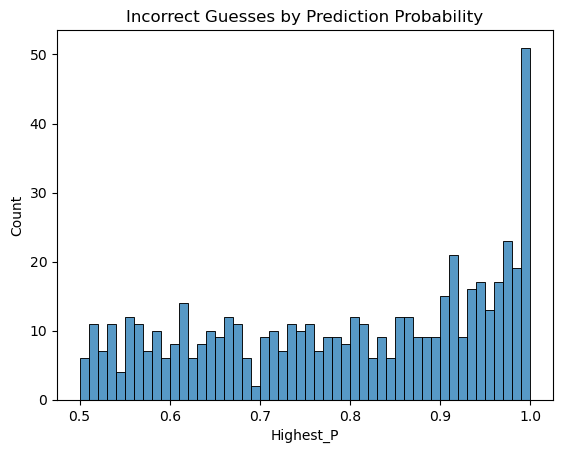

In [53]:
sns.histplot(errors['Highest_P'], binwidth=0.01)
plt.title("Incorrect Guesses by Prediction Probability")

plt.show()

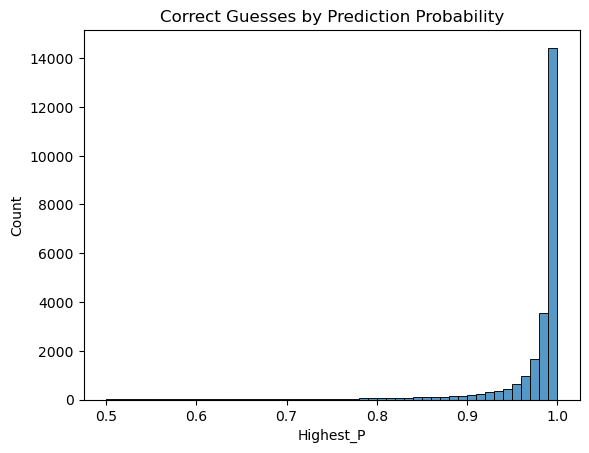

In [54]:
sns.histplot(correct['Highest_P'], binwidth=0.01)
plt.title("Correct Guesses by Prediction Probability")
plt.show()

## Process Description (4 marks)
Please describe the process you used to create your code. Cite any websites or generative AI tools used. You can use the following questions as guidance:
1. Where did you source your code?
1. In what order did you complete the steps?
1. If you used generative AI, what prompts did you use? Did you need to modify the code at all? Why or why not?
1. Did you have any challenges? If yes, what were they? If not, what helped you to be successful?

1) All of the code used in this project was either original code, or sourced from the course notes and course examples.
2) I found the dataset, cleaned it, and then built the pipelines, grid search, and validation for the models. I ended up testing and evaluating four or five different models, troubleshooting various issues with each, until I found three that worked well with the dataset and classification problem. 
3) I did not use any generative AI for this assignment.
4) This dataset was fairly challenging for a number of reasons. I needed to do more background reading on pre-processing and encoding required for multi-classification problems. It was quite challenging trying to configure each of the models with the proper solvers, parameters, and scoring metrics in order to work for a multi-class problem. Some of the models such as SVC() had major issues with trying to converge, which tended to hang the pipeline for a long time with no error messages - I needed to learn to use the verbose parameter to monitor the progress and output of the GridSearch. Other models, such as LogisticRegression() needed tweaking in order to have them converge on a solution. Most of the challenges were solved by careful examination of the ML documentation, and reading discussions on the SKLearn forums.

## Reflection (2 marks)
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challenging, motivating
while working on this assignment.


I really enjoyed the opportunity to complete the ML process from start to finish on a novel dataset. It was motivating to be able to self-select a dataset that was interesting and challenging - this assignment really helped me to understand and assimilate the process involved in creating a pipeline and gridsearch. I really enjoyed that selecting my own dataset forced me to critically think about all of the features of the data, what to use, and how to pre-process it all. 